In [105]:
import numpy as np
import pandas as pd
from munch import Munch
from scipy import stats
from scipy import optimize


# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))


import plotly.express as px
import matplotlib.pyplot as plt

import pchem as pc

def regression(x, y, alternative='two-sided'):
    """Perform a linear regression (using scipy.stats.linregress), 
    compute proper confidence intervals for the slope (slope_95) 
    and intercept (intercept_95), R² (Rsquared), and compute the residuals (residuals).
    
    Everything is output to a single results object, 
    which can be accessed via dictionary or `.` syntax.
    
    Example:
    >>> x = np.array([1, 2, 3])
    >>> y = np.array([2, 4, 6.01])
    >>> r = regression(x, y)
    >>> r.slope
    2.005
    >>> r.slope_95
    0.037
    
    Outputs: an object containing 
        slope
        intercept
        slope_95 
            95% confidence interval for the slope
        intercept_95
            95% confidence interval for the intercept
        Rsquared
            R²
        rvalue
            Correlation coefficient
        stderr
        intercept_stderr
        pvalue
        predict
            function to predict the y value at a given x
        x
        y_predicted
        y
        residual
    
    """
    # Linear regression
    r = stats.linregress(x, y)
    results = Munch(slope=r.slope, intercept=r.intercept,
                    stderr=r.stderr, intercept_stderr=r.intercept_stderr,
                    rvalue=r.rvalue, pvalue=r.pvalue, Rsquared=r.rvalue**2)
    # T-value to convert from standard error to confidence interval 
    # (0.05 means 1 - 0.05 = 95% interval)
    ts = tinv(0.05, len(x) - 2) # Degrees of freedom
    
    # Uncertainties...
    results.slope_95 = results.stderr * ts
    results.intercept_95 = results.intercept_stderr * ts

    results.predict = lambda x: x * results.slope + results.intercept
    results.y_predicted = results.predict(x)
    results.x = x
    results.y = y
    results.residual = results.y - results.y_predicted
    
    return results

def curve_fit(func, x, y, p0=None):
    """Perform a curve fit (using scipy.optimize.curve_fit), 
    compute proper confidence intervals for the slope (slope_95) 
    and intercept (intercept_95), R² (Rsquared), and compute the residuals (residuals).
    
    Everything is output to a single results object, 
    which can be accessed via dictionary or `.` syntax.
    
    
    Outputs: an object containing 
        popt
            optimal values of the parameters
        popt_95 
            95% confidence interval for the slope
        stderr
        intercept_stderr
        predict
            function to predict the y value at a given x
        x
        y_predicted
        y
        residual
    
    """
    # Linear regression
    popt, pcov = optimize.curve_fit(func, x, y, p0=p0)
    results = Munch(popt=popt, pcov=pcov, stderr=np.sqrt(np.diag(pcov)))
    
    
    # T-value to convert from standard error to confidence interval 
    # (0.05 means 1 - 0.05 = 95% interval)
    ts = tinv(0.05, len(x) - len(popt)) # Degrees of freedom
    
    # Uncertainties...
    results.popt_95 = results.stderr * ts

    results.predict = lambda x: func(x, *popt)
    results.y_predicted = results.predict(x)
    results.x = x
    results.y = y
    results.residual = results.y - results.y_predicted
    
    results.RSME = np.sqrt(np.mean(results.residual**2))
    
    return results

## Standard van't Hoff equilibrium analysis

From class, the key equation we use to analyze chemical equilibria is

$$
\Delta_\text{r}G = \Delta_\text{r}H^\circ - T(\Delta_\text{r}S^\circ + R \ln{Q})
$$

At equilibrium, we have $\Delta_\text{r}G =0$ and $Q = K$. Over a small temperature range, we have

$$
\ln{K(T)}  \approx -\frac{\Delta_\text{r}H^{\circ}}{R} \frac{1}{T} + \frac{\Delta_\text{r}S^\circ}{R} 
$$

Over wider temperature ranges, we can modify the equation by accounting for changes in $\Delta_\text{r}H^{\circ}$ and $\Delta_\text{r}S^{\circ}$ with respect to temperature (at constant pressure).

$$
\begin{align}
H(T)& = H(T_0) + \int_{T_0}^{T} C_P \,dT'\\
\Delta_\text{r} H^\circ (T)& = \Delta_\text{r} H^\circ (T_0) + \int_{T_0}^{T} \Delta_\text{r} C_P \,dt 
\end{align}
$$
And our final approximation is
$$
\boxed{
\Delta_\text{r} H^\circ (T) \approx \Delta_\text{r} H^\circ (T_0) + \Delta_\text{r} C_P \, (T-T_0)
}
$$

Similarly for entropy, we have



$$
\begin{align}
S(T)& = S(T_0) + \int_{T_0}^{T} \frac{C_P}{T} \, dT' \\
\Delta_\text{r} S^\circ (T)& = \Delta_\text{r} S^\circ (T_0) + \int_{T_0}^{T} \frac{\Delta_\text{r} C_P}{T} \, dT' 
\end{align}
$$

And our final approximation is

$$
\boxed{\Delta_\text{r} S^\circ (T) \approx \Delta_\text{r} S^\circ (T_0) + \Delta_\text{r} C_P \ln \left (\frac{T}{T_0} \right )}
$$

In [126]:
def eq_analysis(T, K):
    """Standard equilibrium analysis but using curve_fit rather
    than linear regression."""
    R = 8.3145
    lnK = np.log(K)
    
    # This the function that we will curve fit - lnK vs T
    def lnKfunc(T, DeltaH, DeltaS):
        """Use DeltaH in kJ/mol, DeltaS in J/mol-K"""
        # Initial basic analysis, assuming DeltaH and DeltaS are ind.
        # of temperature.
        return -DeltaH*1e3/(R*T) + DeltaS/R
    
    # Do a curve fit
    r = curve_fit(lnKfunc, T, lnK)
    
    # Save parameters to their own variables
    r.DeltaH, r.DeltaS = r.popt
    r.DeltaH_95, r.DeltaS_95 = r.popt_95
    
    # Nice printout of the results
    print(f"RSME = {r.RSME:.4g}")
    print(f"ΔᵣH° = {r.DeltaH:.4g} ± {r.DeltaH_95:.4g} kJ/mol")
    print(f"ΔᵣS° = {r.DeltaS:.4g} ± {r.DeltaS_95:.4g} J/mol-K")
    return r

## Python problem

1. Copy and modify the `eq_analysis` function above to allow cP to vary. You'll need to 
    - define the average / mean temperature as $T_0$ (see equations above)
    - You'll need to add another parameter for the heat capacity difference to the function `lnKfunc` and define DeltaH, DeltaS versus T.
2. Use the function to determine the change in enthalpy, entropy, and heat capacity for the sample data set from last week (included below). 


# Equilibrium analysis - A9 Dataset

Data from 2ClO(g) ⇌ (ClO)₂(g)

In [122]:
T_sample = np.array([233, 248, 258, 268, 273, 280, 288, 295, 303])
K_sample = np.array([4.13e8, 5e7, 1.45e7, 5.37e6, 3.2e6, 9.62e5, 4.28e5, 1.67e5, 6.02e4])

In [129]:
r = eq_analysis(T_sample, K_sample)

RSME = 0.2399
ΔᵣH° = -73.06 ± 5.912 kJ/mol
ΔᵣS° = -146.5 ± 21.96 J/mol-K


Text(0, 0.5, 'ln(K)')

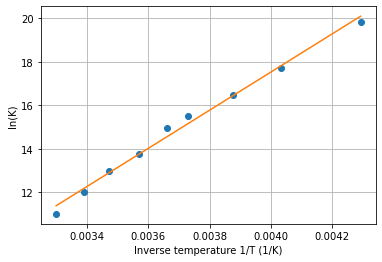

In [130]:
plt.plot(1/r.x, r.y, 'o')
plt.plot(1/r.x, r.y_predicted,)
plt.grid()
plt.xlabel('Inverse temperature 1/T (1/K)')
plt.ylabel("ln(K)")

Text(0, 0.5, 'Residual ln(K)')

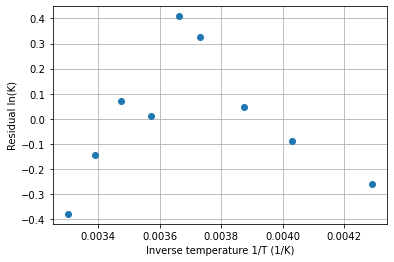

In [133]:
plt.plot(1/r.x, r.residual, 'o')
plt.grid()
plt.xlabel('Inverse temperature 1/T (1/K)')
plt.ylabel("Residual ln(K)")

Initially, there is a significant non-random residual.

## Data set 2

For this dataset,

1. Determine the change in enthalpy, entropy, and heat capacity for the reaction.
2. Plot $\ln{K}$ versus $1/T$ and the residual versus $1/T$ as shown below.
3. Reproduce the plot from the paper, showing $\Delta H$ vs $T$.

The raw data comes from [doi: 10.1016/j.bbagen.2017.11.020](https://doi.org/10.1016/j.bbagen.2017.11.020). The reaction is an association

A(aq) + B(aq) ⇌ AB(aq).

The SI shows how $\Delta H$ varies with $T$ - note that the units are kcal rather than kJ.

<div>
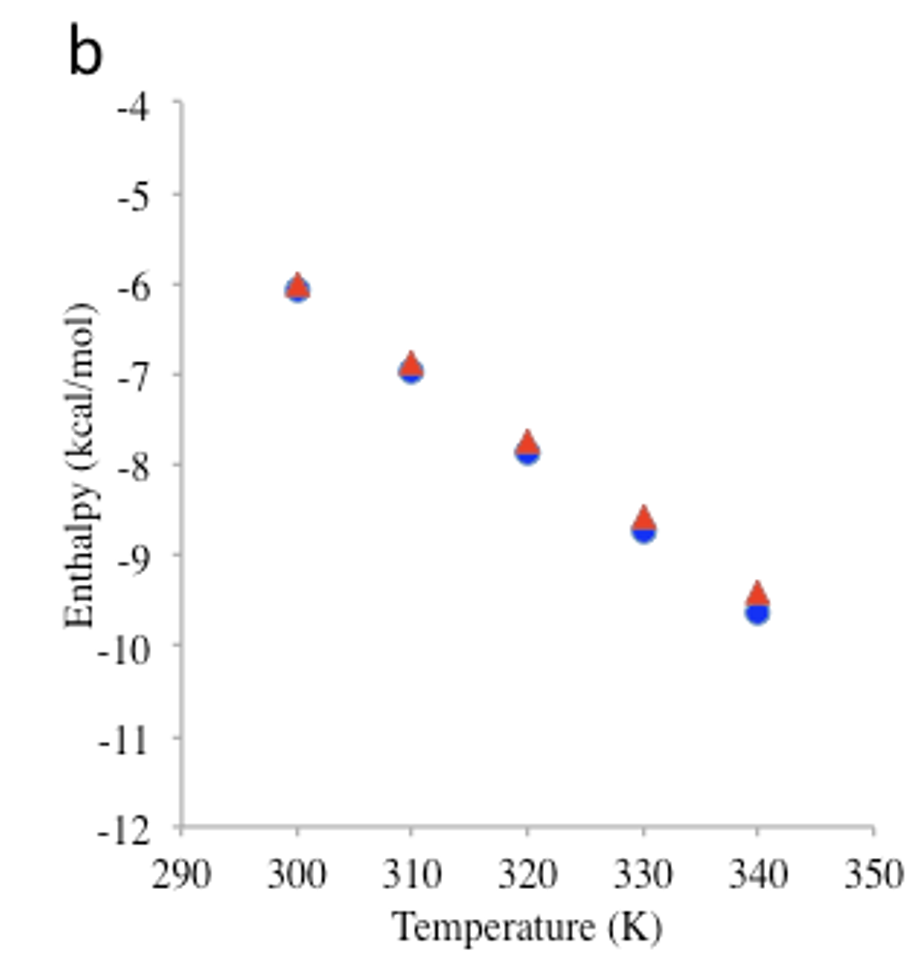
</div>

Here's the data:

```python
T2 = np.array([300, 310, 320, 330, 340])
K2 = np.array([36800, 25900, 17800, 12000, 7990])
```

